# DSP - Overlap and Add Exercise
***
**Federal University of Campina Grande (Universidade Federal de Campina Grande)**

Author: **João Pedro Melquiades Gomes**

Email: **joao.melquiades@ee.ufcg.edu.br**

***
## Introduction
***

When we are processing signals in real time, we cannot process the entire signal once (convolution, fourier, etc.). Instead, we divide the signal in blocks, and apply the overlap and add method to obtain the full processed signal. The following figure illustrate this process to calculate the convolution $y[n] = x[n]*h[n]$:

![title](figures/convolution_overlap_and_add.png)

So, in this exercise I will make the convolution of the signal

<center>$x[n] = cos(\frac{2\pi n}{21})$</center>

added with noise

<center>$\eta[n] = 0.2(-1)^n\delta(n)$</center>

resulting in the signal $r[n] = x[n] + \eta[n]$

The $h[n]$ in this case will be:

<center>$h[n] = 0.5\delta(0) + 0.5\delta(1)$</center>

The parameters of the convolution:
* $M = 2^{13}$ (Size of $x[n]$);
* $L = 2$ (Size of $h[n]$);
* $M_0 = 128$ (Size of blocks).

So, let's start coding.


In [1]:
# important imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
# Parameters
M = 2**13
L = 2
M0 = 2**7

# Defining arrays
n = np.arange(0, M)
x = np.cos(2*np.pi*n/21)
eta = 0.2*(-1)**n*1 # 1 represents the impulse
r = x + eta

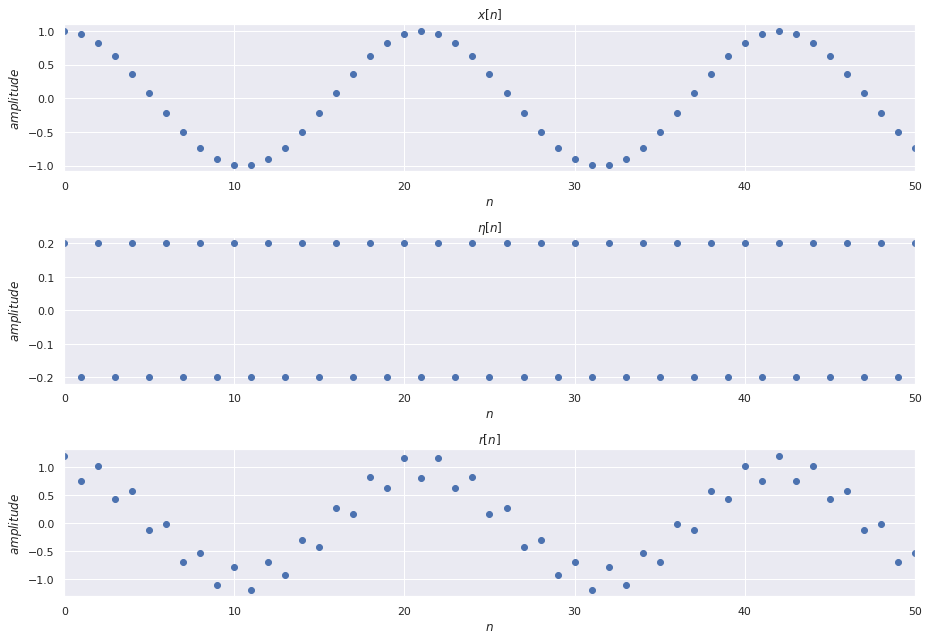

In [15]:
# plotting the signals

plt.figure(figsize=(13, 9))

plt.subplot(3, 1, 1)
plt.scatter(n, x)
plt.title('$x[n]$')
plt.xlabel('$n$')
plt.ylabel('$amplitude$')
plt.xlim(0, 50)

plt.subplot(3, 1, 2)
plt.scatter(n, eta)
plt.title('$\eta[n]$')
plt.xlabel('$n$')
plt.ylabel('$amplitude$')
plt.xlim(0, 50)

plt.subplot(3, 1, 3)
plt.scatter(n, r)
plt.title('$r[n]$')
plt.xlim(0, 50)
plt.xlabel('$n$')
plt.ylabel('$amplitude$')
plt.tight_layout()
plt.show()

To the convolution process, the equation is:

<center>$$y_k[n] = \sum_{i=0}^{M_0+L-1}x_k[i]h[n-i]$$</center>

To transform the circular convolution in the linear convolution, I will padd with 0 both $x_k[n]$ and $h[n]$ until it reaches the size of the convolution $M_0 + L - 1$. So, the convolution can be calculated as follow:

<center>$$y_k[n] = \sum_{i=0}^{M_0+L-1}x_k[i]h[(n-i) \; mod \; (M_0 + L - 1)]$$</center>

Where the size of $y[n]$ will be $M_0 + L - 1$, as shown before

In [16]:
# defining iterable of size L
def grouped(iterable, n):
    "s -> (s0,s1,s2,...sn-1), (sn,sn+1,sn+2,...s2n-1), (s2n,s2n+1,s2n+2,...s3n-1), ..."
    return zip(*[iter(iterable)]*n)

# Covoluting



for 